# Function Calling with Langchain

This tutorial will walk through how to use OpenAI's function call with a few examples:

- Reproduce the weather API example from OpenAI's blog
- Reproduce the same example but also use langchain
- Use the same practice for a real self-hosted API (text2pokemon)

By the end of the tutorial, you will be able to have a langchain app that
- Takes natural langaguge requests like "Create five versions for Abraham Lincoln with very high guidance scale using 38 steps"
- Processes the request using a text2Pokemon API with parameters `{'prompt': 'Abraham Lincoln', 'n_samples': 5, 'steps': 38, 'scale': 12.0}`

In [1]:
import langchain
import openai
import json
import os

## Reproduce Weather API In OpenAI's Blog

Let's run through OpenAI's vanilla example of calling a "fake" weather API, which is a python function that always returns the same weather info regardless which location you query.

The first step is to create the function description. We simply copy the description from the [OpenAI blog](https://openai.com/blog/function-calling-and-other-api-updates).

In [2]:
function_descriptions = [
    {
      "name": "get_current_weather",
      "description": "Get the current weather in a given location",
      "parameters": {
        "type": "object",
        "properties": {
          "location": {
            "type": "string",
            "description": "The city and state, e.g. San Francisco, CA"
          },
          "unit": {
            "type": "string",
            "enum": ["celsius", "fahrenheit"],
            "description": "The temperature unit to use. Infer this from the users location.",
          }
        },
        "required": ["location", "unit"]
      }
    }
]

Now we can curl `https://api.openai.com/v1/chat/completions` with models that support function call (`gpt-3.5-turbo-0613` and `gpt-4-0613`). But since we use Jupyter why not just do it with the Python API.

Notice: the "Infer this from the users location." bit in the description for `unit` is crucial for the model to switch between celsius and fahrenheit (thank Greg Kamradt for the [great idea](https://github.com/gkamradt/langchain-tutorials/blob/main/data_generation/Exploring%20ChatGPT%20Function%20Calling.ipynb)). Hopefully you have found out United States is the primary country that uses Fahrenheit as its official temperature scale. 

In [3]:
user_query = "What's the weather like in Palo Alto?" # Try London and see if anything changes in the response :-)
openai_model_name = "gpt-4-0613" # You can also try gpt-3.5-turbo-0613, but gpt-4-0613 is definitely smarter
function_call = "auto" # allow the model to choose whether or not it responds with a function.

response = openai.ChatCompletion.create(
    model=openai_model_name,    
    
    messages=[{"role": "user", "content": user_query}],
            
    functions=function_descriptions,
    
    function_call="auto",
)

print(response)

{
  "id": "chatcmpl-7fblYv94h861nsP7lvad26CFBLpKb",
  "object": "chat.completion",
  "created": 1690150976,
  "model": "gpt-4-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": null,
        "function_call": {
          "name": "get_current_weather",
          "arguments": "{\n  \"location\": \"Palo Alto, CA\",\n  \"unit\": \"fahrenheit\"\n}"
        }
      },
      "finish_reason": "function_call"
    }
  ],
  "usage": {
    "prompt_tokens": 97,
    "completion_tokens": 28,
    "total_tokens": 125
  }
}


Now, let's make a general interface to execute all functions and arbitary input args.

In [4]:
def execute_function(func, *args, **kwargs):
    try:
        result = func(*args, **kwargs)
        return result
    except Exception as e:
        return f"Error: {e}"

Let's also make a dummy get_current_weather function that always returns the same weather

In [5]:
def get_current_weather(location, unit):
    
    """Get the current weather in a given location"""
    
    weather_info = {
        "location": location,
        "temperature": "75",
        "unit": unit,
        "forecast": ["sunny", "windy"],
    }
    return json.dumps(weather_info)

Now let's make a call use the reponse from ChatCompletion. It should return the dummy weather info but with the correct location and unit.

In [6]:
func = eval(response["choices"][0]["message"]['function_call']['name'])

kwargs = eval(response["choices"][0]["message"]['function_call']['arguments'])

function_response = execute_function(func, **kwargs)

print("function input:")
print(func)
print(kwargs)
print("function response: ")
print(function_response)

function input:
<function get_current_weather at 0x7f1390c01360>
{'location': 'Palo Alto, CA', 'unit': 'fahrenheit'}
function response: 
{"location": "Palo Alto, CA", "temperature": "75", "unit": "fahrenheit", "forecast": ["sunny", "windy"]}


We can also pass the function response back to the model to generate a natural language response

In [7]:
second_response = openai.ChatCompletion.create(
    model=openai_model_name,
    messages=[
        {"role": "user", "content": user_query},
        response["choices"][0]["message"],
        {
            "role": "function",
            "name": "get_current_weather",
            "content": function_response,
        },
    ],
)
print (second_response)

{
  "id": "chatcmpl-7fblajWyVdpCUQZ7TBPruQ15wCQSk",
  "object": "chat.completion",
  "created": 1690150978,
  "model": "gpt-4-0613",
  "choices": [
    {
      "index": 0,
      "message": {
        "role": "assistant",
        "content": "The weather in Palo Alto, CA is currently sunny and windy with a temperature of 75\u00b0F."
      },
      "finish_reason": "stop"
    }
  ],
  "usage": {
    "prompt_tokens": 87,
    "completion_tokens": 20,
    "total_tokens": 107
  }
}


## Do the same thing in Langchain

Langchain has made it very easy to use OpenAI's function.

Let's first import a few langchain modules.

In [8]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, AIMessage, ChatMessage

In [9]:
llm = ChatOpenAI(model=openai_model_name)

To use function call, simply pass the `function_descriptions` while you are making the `llm.predict_messages` call

In [10]:
response = llm.predict_messages([HumanMessage(content=user_query)],
                                functions=function_descriptions)
print(response)

content='' additional_kwargs={'function_call': {'name': 'get_current_weather', 'arguments': '{\n  "location": "Palo Alto, CA",\n  "unit": "fahrenheit"\n}'}} example=False


Now we can call `execute_function` use the reponse as we did before:

In [11]:
func = eval(response.additional_kwargs['function_call']['name'])
kwargs = eval(response.additional_kwargs['function_call']['arguments'])
function_response = execute_function(func, **kwargs)

print(func)
print(kwargs)
print(function_response)

<function get_current_weather at 0x7f1390c01360>
{'location': 'Palo Alto, CA', 'unit': 'fahrenheit'}
{"location": "Palo Alto, CA", "temperature": "75", "unit": "fahrenheit", "forecast": ["sunny", "windy"]}


And create a natural langauge response too. Notice how AIMessage and ChatMessage as the assitant role and function role.

In [12]:
function_name = response.additional_kwargs["function_call"]["name"]
second_response = llm.predict_messages([HumanMessage(content=user_query),
                                        AIMessage(content=str(response.additional_kwargs)),
                                        ChatMessage(role='function',
                                                    additional_kwargs = {'name': function_name},
                                                    content = function_response
                                                   )
                                       ],
                                       functions=function_descriptions)
print(second_response)

content='The current weather in Palo Alto, CA is 75°F. The forecast is sunny and windy.' additional_kwargs={} example=False


# LangChain Text2Pokemon Example

Now, instead of using the dummy weather API, let's actually let the model do something. 

We will create a text2Pokemon function and see if it can be called using natural language. 

First, let's create the text2Pokemon function:

In [13]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline

def null_safety(images, **kwargs):
    return images, False
        
device = "cuda:1" if torch.cuda.is_available() else "cpu"
context = autocast if device == "cuda:1" else nullcontext
dtype = torch.float16 if device == "cuda:1" else torch.float32

pipe = StableDiffusionPipeline.from_pretrained(
    "lambdalabs/sd-pokemon-diffusers", torch_dtype=dtype
)
pipe = pipe.to(device)
pipe.safety_checker = null_safety

def text2Pokemon(prompt, n_samples, steps, scale):
    print('---------------------------------')
    print(prompt)
    print(n_samples)
    print(steps)
    print(scale)
    print('---------------------------------')
    with context("cuda"):
        images = pipe(
            n_samples * [prompt], guidance_scale=scale, num_inference_steps=steps
        ).images

    return images

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [14]:
function_descriptions = [
            {
                "name": "text2Pokemon",
                "description": "Generate images of Pokemon creatures from a text description of the creature.",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "prompt": {
                            "type": "string",
                            "description": "The text description of the creature",
                        },
                        "n_samples": {
                            "type": "number",
                            "description": "The number of output images. Default to 2.",
                        },
                        "steps": {
                            "type": "number",
                            "description": "The number of iteration steps for the algorithm. Default to 20.",
                        },
                        "scale": {
                            "type": "number",
                            "description": "The guidance scale which controls how much the generated image should follow the prompt. The larger the value, the more closely the generated images follow the prompt. Typically value is somewhere between 7.0 to 13.0. Default to 10.0",
                        },
                    },
                    "required": ["object", "n_samples", "steps", "scale"],
                },
            }
        ]

In [15]:
user_request = "Create five versions for Abraham Lincoln with very high guidance scale using 38 steps."

In [16]:
llm = ChatOpenAI(model="gpt-4-0613")

response = llm.predict_messages([HumanMessage(content=user_request)],
                                      functions=function_descriptions)
response

AIMessage(content='', additional_kwargs={'function_call': {'name': 'text2Pokemon', 'arguments': '{\n  "prompt": "Abraham Lincoln",\n  "n_samples": 5,\n  "steps": 38,\n  "scale": 13.0\n}'}}, example=False)

In [17]:
func = eval(response.additional_kwargs['function_call']['name'])
kwargs = eval(response.additional_kwargs['function_call']['arguments'])
function_response = execute_function(func, **kwargs)

print(func)
print(kwargs)
print(function_response)


---------------------------------
Abraham Lincoln
5
38
13.0
---------------------------------


  0%|          | 0/38 [00:00<?, ?it/s]

<function text2Pokemon at 0x7f1314fa2950>
{'prompt': 'Abraham Lincoln', 'n_samples': 5, 'steps': 38, 'scale': 13.0}
[<PIL.Image.Image image mode=RGB size=512x512 at 0x7F12DE986C20>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F12DDFA4400>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F12DDFA4490>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F12DDFA43A0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x7F12DDFA4370>]


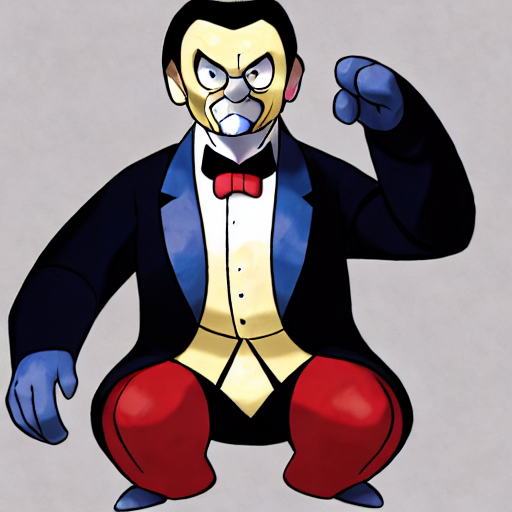

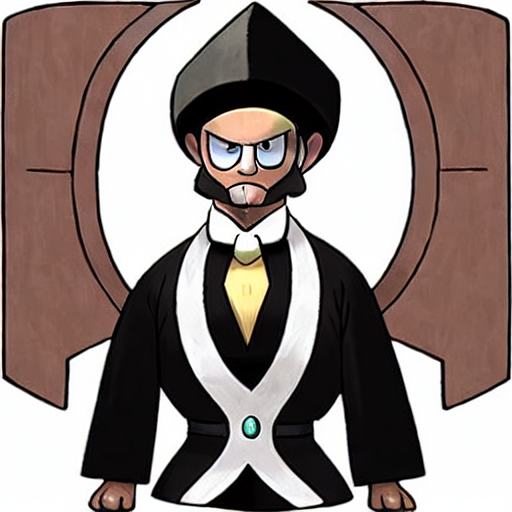

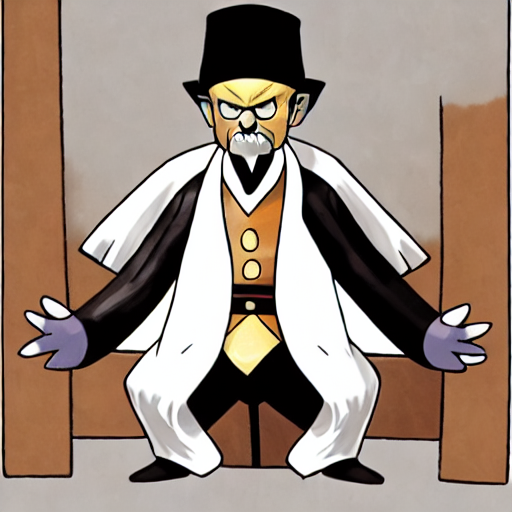

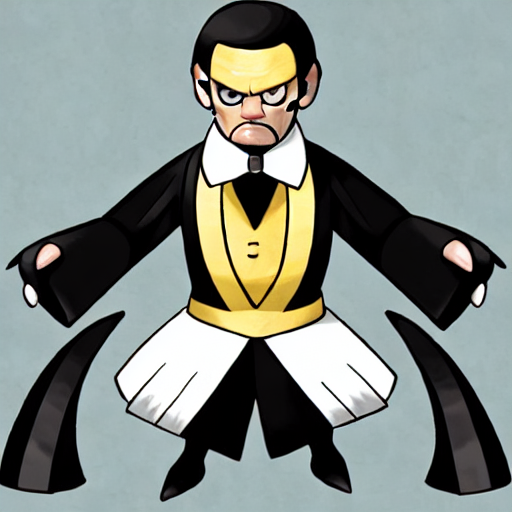

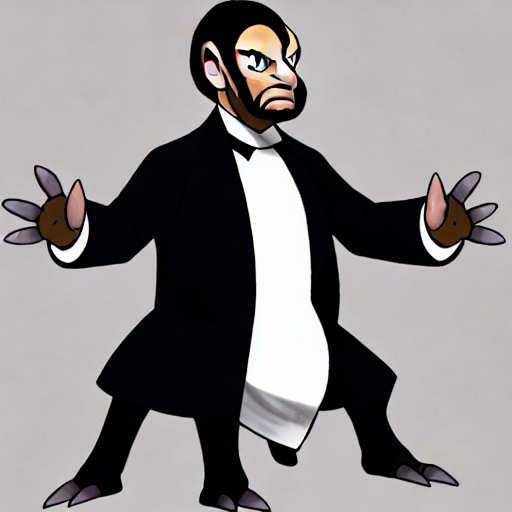

In [18]:
from IPython.display import display
from PIL import Image
for image in function_response:
    display(image)